# Импорты

In [2]:
!pip install keras

^C
Traceback (most recent call last):
  File "<frozen importlib._bootstrap_external>", line 153, in _path_is_mode_type
  File "<frozen importlib._bootstrap_external>", line 147, in _path_stat
FileNotFoundError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.10/site-packages/pip/_internal/utils/__init__.cpython-310-x86_64-linux-gnu.so'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/bin/pip", line 6, in <module>
    from pip._internal.cli.main import main
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/__init__.py", line 3, in <module>
    from pip._internal.utils import _log
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1002, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 945, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1439, in find_spec
  File "<frozen importlib._boo

In [3]:
!pip install --upgrade tensorflow

^C
ERROR: Operation cancelled by user


In [49]:
import pandas as pd
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import pickle
import re

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Embedding, Dense, Concatenate, Bidirectional, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

# Данные

In [3]:
binary_train = pd.read_csv('/kaggle/input/tables/binary_train2.csv')
binary_valid = pd.read_csv('/kaggle/input/tables/binary_valid2.csv')
binary_test = pd.read_csv('/kaggle/input/tables/binary_test2.csv')

In [4]:
binary_train.head()

,question,answer,image_path
0,is embolus derived from a lower-extremity deep...,yes,/kaggle/input/images-path-vqa/images/train/ima...
1,is normal palmar creases present?,no,/kaggle/input/images-path-vqa/images/train/ima...
2,does this image show excellent photo typical a...,yes,/kaggle/input/images-path-vqa/images/train/ima...
3,does typical tuberculous exudate show excellen...,no,/kaggle/input/images-path-vqa/images/train/ima...
4,is gastrointestinal present?,yes,/kaggle/input/images-path-vqa/images/train/ima...


Question:  is edema present?
Answer:  no


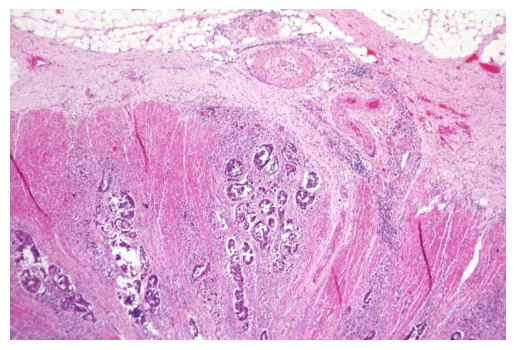

In [5]:
np.random.seed(2)
idx = np.random.randint(0, 10)

print('Question: ', binary_train.iloc[idx, 0])
print('Answer: ',  binary_train.iloc[idx, 1])
img_path = binary_train.iloc[idx, 2]
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

# Подготовка данных

**LABELS**

In [6]:
labels_train = binary_train['answer'].replace({'yes': 1, 'no': 0}).tolist()
labels_test = binary_test['answer'].replace({'yes': 1, 'no': 0}).tolist()
labels_valid = binary_valid['answer'].replace({'yes': 1, 'no': 0}).tolist()

**WORD SEQUENCES**

In [7]:
docx_train = np.array(binary_train["question"].tolist())
docx_val = np.array(binary_valid["question"].tolist())
docx_test = np.array(binary_test["question"].tolist())

all_texts = np.concatenate((docx_train, docx_val, docx_test))

tokenizer = Tokenizer(oov_token="<nothing>")
tokenizer.fit_on_texts(all_texts)

train_sequences = tokenizer.texts_to_sequences(docx_train)
val_sequences = tokenizer.texts_to_sequences(docx_val)
test_sequences = tokenizer.texts_to_sequences(docx_test)


max_len = max(len(x) for x in train_sequences)
train_sequences = pad_sequences(train_sequences, padding="post", maxlen=max_len)
val_sequences = pad_sequences(val_sequences, padding="post", maxlen=max_len)
test_sequences = pad_sequences(test_sequences, padding="post", maxlen=max_len)

sequences = np.concatenate((train_sequences, val_sequences, test_sequences), axis=0)

Сохраним обученный токенизатор:

In [8]:
# Сохранение токенизатора в файл
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

**IMAGES**

In [9]:
train_addresses = binary_train["image_path"].tolist()
val_addresses = binary_valid["image_path"].tolist()
test_addresses = binary_test["image_path"].tolist()

ytrain = labels_train
yval = labels_valid
ytest = labels_test

**PIPELINE**

In [10]:
def augment_data(pair, label):
    image, sequence = pair
    # Random rotate
    angle = tf.random.uniform([], minval=-60, maxval=60, dtype=tf.float32)
    image = tf.image.rot90(image, tf.cast(angle / 90, dtype=tf.int32))

    # Random shift
    shift_x = tf.random.uniform(shape=[], minval=-50, maxval=50, dtype=tf.int32)
    shift_y = tf.random.uniform(shape=[], minval=-50, maxval=50, dtype=tf.int32)
    image = tf.roll(image, shift_x, axis=1)
    image = tf.roll(image, shift_y, axis=0)

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.8)
    
    # Random contract
    image = tf.image.random_contrast(image, lower=0.1, upper=1.5)

    return (image, sequence), label

def process_data(image_path, text_sequence, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image/255, dtype = tf.float32)
    return (image, text_sequence), label

BATCH_SIZE = 16
BUFFER_SIZE = 250 

train_data = tf.data.Dataset.from_tensor_slices((train_addresses, train_sequences, ytrain))
val_data = tf.data.Dataset.from_tensor_slices((val_addresses, val_sequences, yval))

train_data = train_data.map(process_data)
augmented_data = train_data.map(augment_data)
train_data  = train_data.concatenate(augmented_data)

train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.shuffle(buffer_size=BUFFER_SIZE)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

val_data = val_data.map(process_data)
val_data = val_data.batch(BATCH_SIZE)
val_data = val_data.shuffle(buffer_size=BUFFER_SIZE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)


train_data, val_data

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 36), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 36), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [11]:
(images, seqs), labs = next(iter(train_data))
images.shape, seqs.shape, labs.shape

(TensorShape([16, 256, 256, 3]), TensorShape([16, 36]), TensorShape([16]))

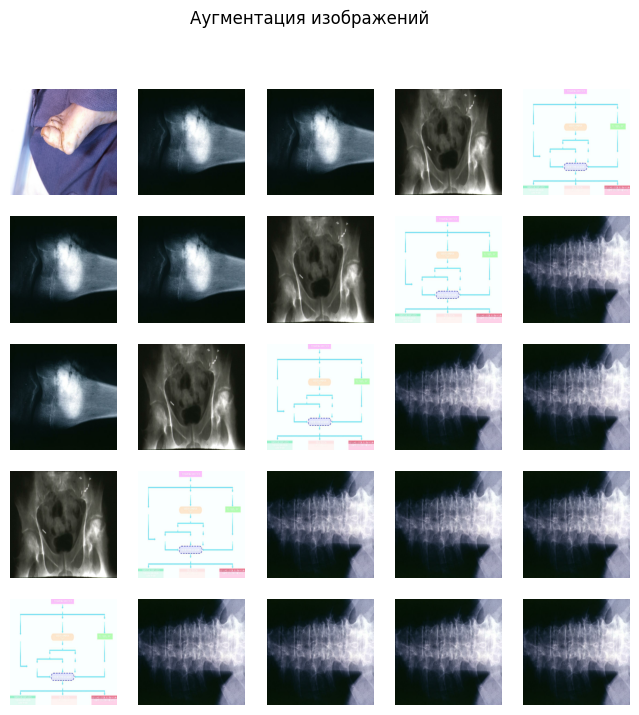

In [12]:
fig, ax = plt.subplots(5,5, figsize = (8, 8))
fig.suptitle('Аугментация изображений', fontsize=12)

for i in range(5):
    ax[i][0].imshow(images[i])
    ax[i][0].axis('off')
    ax[i][1].imshow(images[i+1])
    ax[i][1].axis('off')
    ax[i][2].imshow(images[i+2])
    ax[i][2].axis('off')
    ax[i][3].imshow(images[i+3])
    ax[i][3].axis('off')
    ax[i][4].imshow(images[i+4])
    ax[i][4].axis('off')

**CNN LSTM encoder**

In [20]:
vocab_size = sequences.max() + 1

image_input = Input(shape=(256, 256, 3), name='image_input')
text_input = Input(shape=(36,), name='text_input')

image_branch = Conv2D(64, (3, 3), activation='relu', padding="same")(image_input)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.2)(image_branch)
image_branch = Conv2D(32, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.1)(image_branch)
image_branch = Conv2D(32, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.1)(image_branch)
image_branch = Flatten()(image_branch)

text_branch = Embedding(input_dim=vocab_size, output_dim=64)(text_input)
text_branch = Bidirectional(LSTM(64, return_sequences=False))(text_branch)
text_branch = Dropout(0.2)(text_branch)

combined = Concatenate()([image_branch, text_branch])
combined = Dropout(0.5)(combined) #0.2
combined = Dense(512, activation="relu")(combined)
combined = Dense(256, activation="relu")(combined)
combined = Dense(128, activation="relu")(combined)

output = Dense(1, activation='sigmoid')(combined)

model = keras.Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

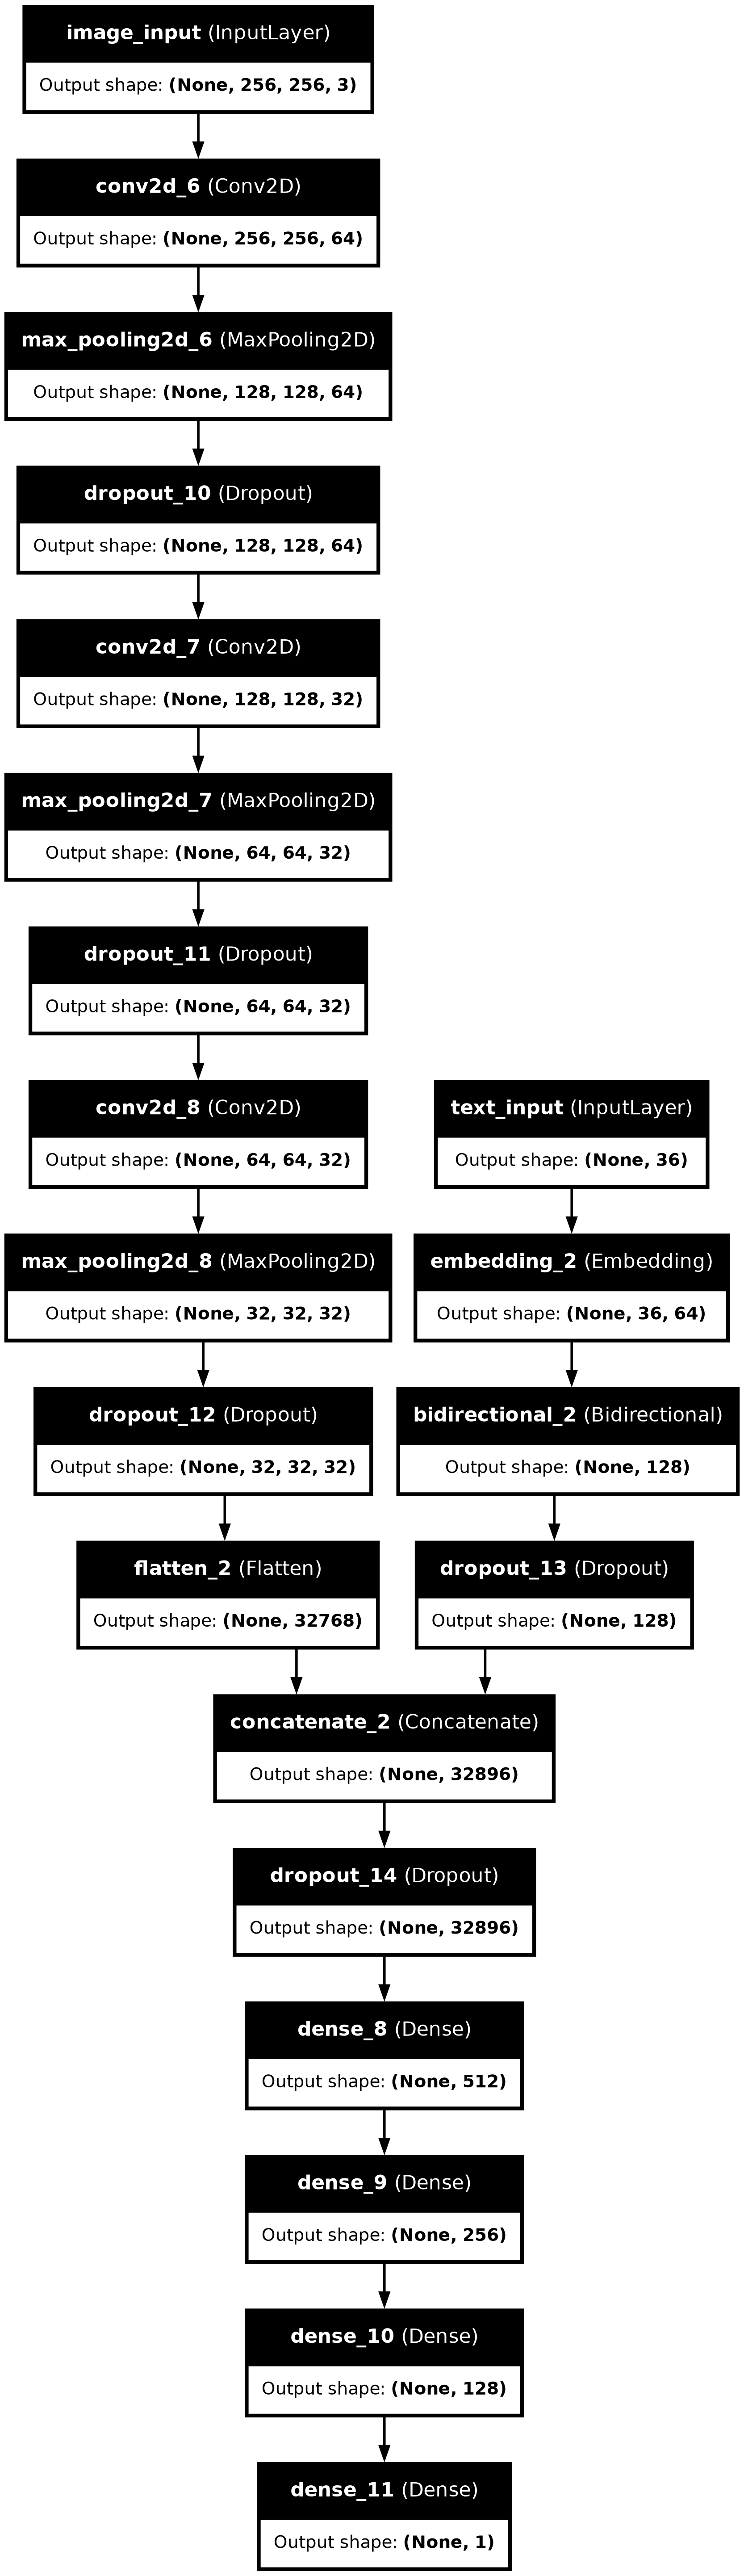

In [21]:
plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)

In [22]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/best.keras',
                                                  verbose=1, save_best_only = True, monitor='val_accuracy')

history = model.fit(
    train_data,
    epochs=15, batch_size=16,
    validation_data = val_data,
    callbacks = checkpointer
         )

Epoch 1/15


2024-08-14 09:08:03.429526: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7308 - loss: 0.5056
Epoch 1: val_accuracy improved from -inf to 0.81728, saving model to /kaggle/working/best.keras
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 151s 112ms/step - accuracy: 0.7309 - loss: 0.5056 - val_accuracy: 0.8173 - val_loss: 0.3542
Epoch 2/15
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8745 - loss: 0.2838
Epoch 2: val_accuracy improved from 0.81728 to 0.82240, saving model to /kaggle/working/best.keras
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 128s 100ms/step - accuracy: 0.8745 - loss: 0.2838 - val_accuracy: 0.8224 - val_loss: 0.3819
Epoch 3/15
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8945 - loss: 0.2350
Epoch 3: val_accuracy did not improve from 0.82240
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 126s 98ms/step - accuracy: 0.8945 - loss: 0.2350 - val_accuracy: 0.8192 - val_loss: 0.4121
Epoch 4/15
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9031 - loss: 0.2134
Epoch 4: val_accuracy improved from 0.822

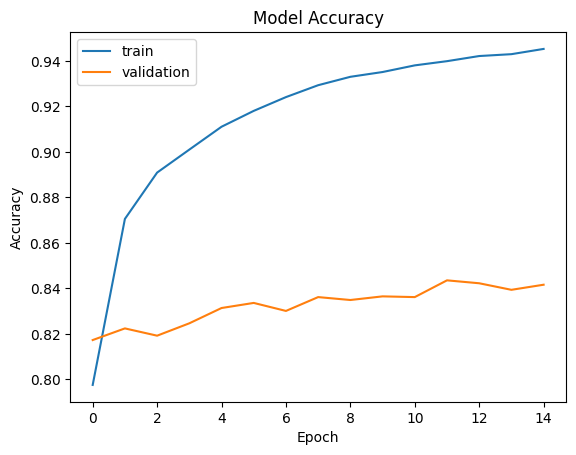

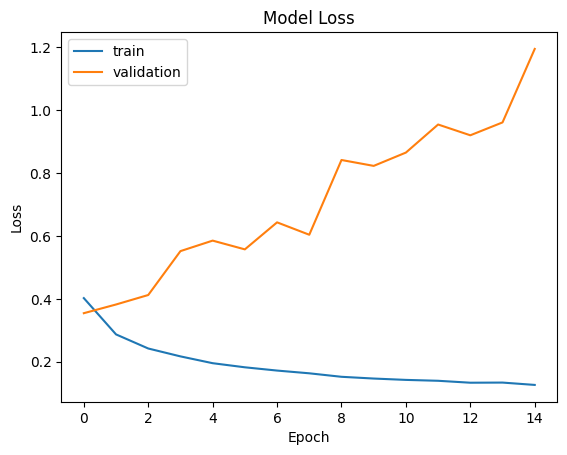

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**TESTING**

In [25]:
BATCH_SIZE = 16
BUFFER_SIZE = 500

test_data = tf.data.Dataset.from_tensor_slices((test_addresses, test_sequences, ytest))
test_data = test_data.map(process_data)
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
(images_test, seqs_test), labs_test = next(iter(test_data))
images_test.shape, seqs_test.shape, labs_test.shape

(TensorShape([16, 256, 256, 3]), TensorShape([16, 36]), TensorShape([16]))

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [28]:
test_loss, test_accuracy, test_auc = model.evaluate(test_data)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test AUC: {test_auc}')

211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.8128 - auc: 0.8641 - loss: 1.4138
Test Loss: 1.272878646850586, Test Accuracy: 0.8390838503837585, Test AUC: 0.8851244449615479


In [48]:
predicted = model.predict(test_data)
predicted_classes = (predicted > 0.5).astype(int)

211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


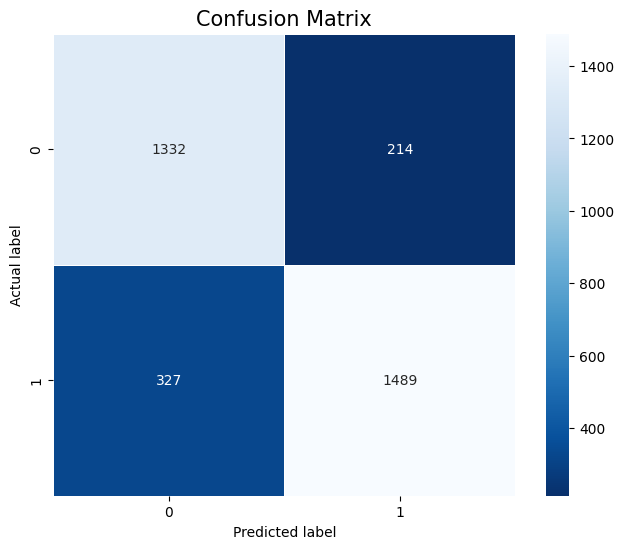

In [50]:
cm = confusion_matrix(ytest, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix', size = 15);
plt.show();